# Segmentation Tracking with DINOv3

This notebook demonstrates using DINOv3 for video segmentation tracking
using a non-parametric method similar to
["Space-time correspondence as a contrastive random walk" (Jabri et al. 2020)](https://arxiv.org/abs/2006.14613).

Given:
- RGB video frames
- Instance segmentation masks for the first frame

We will extract patch features from each frame and use patch similarity
to propagate the ground-truth labels to all frames.

## Setup

Let's start by loading some pre-requisites, setting up the environment and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [1]:
!pip install lovely_tensors
!pip install mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.2 MB/s eta 0:00:00


In [2]:
!pip install gdown

import gdown

# File ID from your Google Drive link
file_id = "1NK1Fq2OUO7ggibNqR8B7JlVC1OCGzFIA"
# Desired output filename
output = "dinov3_vits16_pretrain_lvd1689m-08c60483.pth"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NK1Fq2OUO7ggibNqR8B7JlVC1OCGzFIA
From (redirected): https://drive.google.com/uc?id=1NK1Fq2OUO7ggibNqR8B7JlVC1OCGzFIA&confirm=t&uuid=8d57b07e-6c18-4cde-89f5-b3454b323ea6
To: /content/dinov3_vits16_pretrain_lvd1689m-08c60483.pth
100%|██████████| 86.5M/86.5M [00:02<00:00, 33.9MB/s]


'dinov3_vits16_pretrain_lvd1689m-08c60483.pth'

In [3]:
!git clone https://github.com/facebookresearch/dinov3.git
%cd dinov3
!pip install -r requirements.txt
!pip install -e .

Cloning into 'dinov3'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 334 (delta 77), reused 32 (delta 32), pack-reused 212 (from 2)
Receiving objects: 100% (334/334), 9.82 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/dinov3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.4 MB/s eta 0:00:00
Obtaining file:///content/dinov3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dinov3 (pyproject.toml) ... done
  Created wheel for dinov3: filename=dinov3-0.0.1-0.editable-py3-none-any.whl size=13307 sha256=27024e793

In [4]:
import datetime
import functools
import io
import logging
import math
import os
from pathlib import Path
import tarfile
import time
import urllib

import lovely_tensors
import matplotlib.pyplot as plt
import mediapy as mp
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as TVT
import torchvision.transforms.functional as TVTF
from torch import Tensor, nn
from tqdm import tqdm

DISPLAY_HEIGHT = 200
lovely_tensors.monkey_patch()
torch.set_grad_enabled(False)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

# if os.getenv("DINOV3_LOCATION") is not None:
#     DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
# else:
#     DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

# print(f"DINOv3 location set to {DINOV3_LOCATION}")

## Model

We load the DINOv3 ViT-L model and get some attributes. Feel free to try other DINOv3 models as well!

In [5]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITS

import sys
import torch

REPO_DIR = "/content/dinov3"
if REPO_DIR not in sys.path:
    sys.path.append(REPO_DIR)

# Select device (GPU if available, else CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load weights onto the chosen device
state_dict = torch.load(
    "/content/dinov3_vits16_pretrain_lvd1689m-08c60483.pth",
    map_location=device
)

# Build the model from local repo
model = torch.hub.load(
    REPO_DIR,
    MODEL_NAME,
    pretrained=False,
    source="local",
)

# Load state_dict
model.load_state_dict(state_dict)

# Move to device
model.to(device)
model.eval()

# Print info
patch_size = model.patch_size
embed_dim = model.embed_dim
print(f"Patch size: {patch_size}")
print(f"Embedding dimension: {embed_dim}")

if device == "cuda":
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 2**30:.1f} GB")


Using device: cuda
Patch size: 16
Embedding dimension: 384
Peak GPU memory: 0.2 GB


We want to process one image at the time and get L2-normalized features.
Here is a wrapper to do just that.

In [6]:
@torch.compile(disable=True)
def forward(
    model: nn.Module,
    img: Tensor,  # [3, H, W] already normalized for the model
) -> Tensor:
    feats = model.get_intermediate_layers(img.unsqueeze(0), n=1, reshape=True)[0]  # [1, D, h, w]
    feats = feats.movedim(-3, -1)  # [1, h, w, D]
    feats = F.normalize(feats, dim=-1, p=2)
    return feats.squeeze(0)  # [h, w, D]

## Data

Here we load the video frames and the instance segmentation masks for the first frame.


This notebook assumes that the video has already been processed to extract individual frames as `.jpg` images in the current directory.
```txt
000001.jpg
000002.jpg
...
```

To run this notebook on your own `.mp4` video, use `ffmpeg` to extract frames at 24 FPS:
```bash
INPUT_VIDEO="video.mp4"
OUTPUT_DIR="."
ffmpeg -hide_banner -i "${INPUT_VIDEO}" -qscale:v 2 -vf fps=24 -y "${OUTPUT_DIR}/%06d.jpg"
```

In [7]:
VIDEO_FRAMES_URI = "https://dl.fbaipublicfiles.com/dinov3/notebooks/segmentation_tracking/video_frames.tar.gz"

def load_video_frames_from_remote_tar(tar_uri: str) -> list[Image.Image]:
    images = []
    indices = []
    with urllib.request.urlopen(tar_uri) as f:
        tar = tarfile.open(fileobj=io.BytesIO(f.read()))
        for member in tar.getmembers():
            index_str, _ = os.path.splitext(member.name)
            image_data = tar.extractfile(member)
            image = Image.open(image_data).convert("RGB")
            images.append(image)
            indices.append(int(index_str))
    order = np.argsort(indices)
    return [images[i] for i in order]

frames = load_video_frames_from_remote_tar(VIDEO_FRAMES_URI)
num_frames = len(frames)
print(f"Number of frames: {num_frames}")

original_width, original_height = frames[0].size
print(f"Original size: width={original_width}, height={original_height}")

Number of frames: 174
Original size: width=1920, height=1440


Let's show four sample frames from the video:

Frame 0,Frame 57,Frame 115,Frame 173

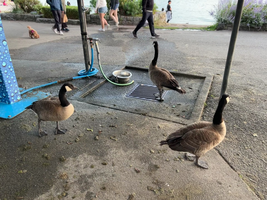
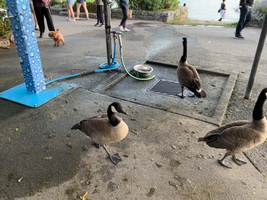
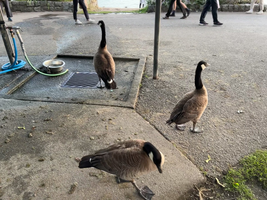
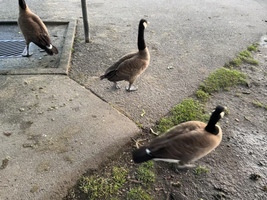

In [8]:
num_selected_frames = 4
selected_frames = np.linspace(0, num_frames - 1, num_selected_frames, dtype=int)

mp.show_images(
    [frames[int(i)] for i in selected_frames],
    titles=[f"Frame {i}" for i in selected_frames],
    height=DISPLAY_HEIGHT,
)

This notebook assumes that instance segmentation masks for the first frame are stored in a `.png` file:
- A value of `0` indicates the background.
- Object instances are represented by progressive contiguous `uint8` indices starting from `1`.

We created the example mask using [SAM 2](), but Paint would work just as well.

A function to visualize the masks as RGB is also provided.

Mask size: [1440, 1920]
Number of masks: 6


Frame,Mask

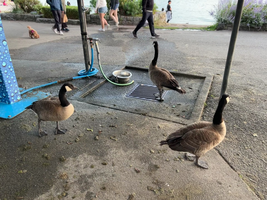
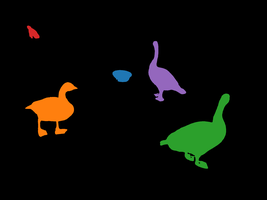

In [9]:
def mask_to_rgb(mask: np.ndarray | Tensor, num_masks: int) -> np.ndarray:
    if isinstance(mask, Tensor):
        mask = mask.cpu().numpy()

    # Exclude background
    background = mask == 0
    mask = mask - 1
    num_masks = num_masks - 1

    # Choose palette
    if num_masks <= 10:
        mask_rgb = plt.get_cmap("tab10")(mask)[..., :3]
    elif num_masks <= 20:
        mask_rgb = plt.get_cmap("tab20")(mask)[..., :3]
    else:
        mask_rgb = plt.get_cmap("gist_rainbow")(mask / (num_masks - 1))[..., :3]

    mask_rgb = (mask_rgb * 255).astype(np.uint8)
    mask_rgb[background, :] = 0
    return mask_rgb


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f)


first_mask_np = np.array(
    load_image_from_url(
        "https://dl.fbaipublicfiles.com/dinov3/notebooks/segmentation_tracking/first_video_frame_mask.png"
    )
)

mask_height, mask_width = first_mask_np.shape  # Abbreviated at [H', W']
print(f"Mask size: {[mask_height, mask_width]}")

num_masks = int(first_mask_np.max() + 1)  # Abbreviated as M
print(f"Number of masks: {num_masks}")

mp.show_images(
    [frames[0], mask_to_rgb(first_mask_np, num_masks)],
    titles=["Frame", "Mask"],
    height=DISPLAY_HEIGHT,
)

Time for some math! Input frames need to be resized to match the desired forward resolution and the model patch size.

The desired forward resolution refers to the _short side_ of the input.
If the desired resolution is not a multiple of the patch size, we simply round it up.
Then, we determine the _long side_ by maintaining the original aspect ratio as much as possible, but rounding up to the patch size as well.

With the occasion, we'll also setup the torchvision transforms and test them out on the first frame.

In [10]:
import math
import torch
import torch.nn as nn
import torchvision.transforms as TVT
import torchvision.transforms.functional as TVTF

class ResizeToMultiple(nn.Module):
    def __init__(self, short_side: int, multiple: int):
        super().__init__()
        self.short_side = short_side
        self.multiple = multiple

    def _round_up(self, side: float) -> int:
        return math.ceil(side / self.multiple) * self.multiple

    def forward(self, img):
        old_width, old_height = TVTF.get_image_size(img)
        if old_width > old_height:
            new_height = self._round_up(self.short_side)
            new_width = self._round_up(old_width * new_height / old_height)
        else:
            new_width = self._round_up(self.short_side)
            new_height = self._round_up(old_height * new_width / old_width)
        return TVTF.resize(
            img,
            [new_height, new_width],
            interpolation=TVT.InterpolationMode.BICUBIC,
        )

# ---- choose device ----
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ---- build transform ----
SHORT_SIDE = 960
transform = TVT.Compose(
    [
        ResizeToMultiple(short_side=SHORT_SIDE, multiple=patch_size),
        TVT.ToTensor(),
        TVT.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# ---- apply transform ----
first_frame = transform(frames[0]).to(device)
print(f"First frame shape: {first_frame.shape}")

# ---- extract dimensions ----
_, frame_height, frame_width = first_frame.shape  # [C, H, W]
feats_height, feats_width = frame_height // patch_size, frame_width // patch_size
print(f"Feature map: {feats_height} x {feats_width}")


Using device: cuda
First frame shape: torch.Size([3, 960, 1280])
Feature map: 60 x 80


Label propagation happens at the output resolution of the model,
so we downsample the ground-truth masks of the first frame and turn them into a one-hot probability map.

In [11]:
import torch
import torch.nn.functional as F

# ---- choose device ----
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ---- move mask to device ----
first_mask = torch.from_numpy(first_mask_np).to(device=device, dtype=torch.long)  # [H', W']

# ---- resize mask ----
first_mask = F.interpolate(
    first_mask[None, None, :, :].float(),  # [1, 1, H', W']
    (feats_height, feats_width),
    mode="nearest-exact",
)[0, 0].long().to(device)  # [h, w]
print(f"First mask:  {first_mask.shape} on {first_mask.device}")

# ---- one-hot encode ----
first_probs = F.one_hot(first_mask, num_masks).float().to(device)  # [h, w, M]
print(f"First probs: {first_probs.shape} on {first_probs.device}")


Using device: cuda
First mask:  torch.Size([60, 80]) on cuda:0
First probs: torch.Size([60, 80, 6]) on cuda:0


## How it works

And now the fun part!

Label propagation takes as input:
- The features of the current frame, with shape `[h, w, D]`
- The features of the `t` context frames, with shape `[t, h, w, D]`
- The mask probabilities of `t` context frames, with shape `[t, h, w, M]`

For each patch of the current frame:
- We compute the cosine similarity with all context patches.
- We restrict the focus to a local neighborhood and select the top-k most similar context patches.
- We compute a weighted average of the mask probabilities of the selected patches to obtain a prediction for the mask probabilies of the current patch.

In [12]:
import torch
import torch.nn.functional as F
import functools
from torch import Tensor

# ---- pick device globally ----
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Disable compile to avoid backend issues
@torch.compile(disable=True)
def propagate(
    current_features: Tensor,   # [h", w", D]
    context_features: Tensor,   # [t, h, w, D]
    context_probs: Tensor,      # [t, h, w, M]
    neighborhood_mask: Tensor,  # [h", w", h, w]
    topk: int,
    temperature: float,
) -> Tensor:
    t, h, w, M = context_probs.shape
    dev = current_features.device  # keep everything consistent

    # Compute similarity current -> context
    dot = torch.einsum(
        "ijd, tuvd -> ijtuv",
        current_features,
        context_features,
    )  # [h", w", t, h, w]

    # Restrict focus to local neighborhood
    dot = torch.where(
        neighborhood_mask[:, :, None, :, :],
        dot,
        torch.full_like(dot, -float("inf"), device=dev),
    )

    # Select top-k patches inside the neighborhood
    dot = dot.flatten(2, -1).flatten(0, 1)  # [h"w", thw]
    k_th_largest = torch.topk(dot, dim=1, k=topk).values  # [h"w", k]
    dot = torch.where(
        dot >= k_th_largest[:, -1:],
        dot,
        torch.full_like(dot, -float("inf"), device=dev),
    )

    # Propagate probabilities from context to current frame
    weights = F.softmax(dot / temperature, dim=1)  # [h"w", thw]
    current_probs = torch.mm(
        weights,
        context_probs.flatten(0, 2),  # [thw, M]
    )  # [h"w", M]

    # Normalize (safety)
    current_probs = current_probs / current_probs.sum(dim=1, keepdim=True)

    return current_probs.unflatten(0, (h, w))  # [h", w", M]


@functools.lru_cache()
def make_neighborhood_mask(h: int, w: int, size: float, shape: str, device: str = None) -> Tensor:
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    ij = torch.stack(
        torch.meshgrid(
            torch.arange(h, dtype=torch.float32, device=device),
            torch.arange(w, dtype=torch.float32, device=device),
            indexing="ij",
        ),
        dim=-1,
    )  # [h, w, 2]

    if shape == "circle":
        ord = 2
    elif shape == "square":
        ord = torch.inf
    else:
        raise ValueError(f"Invalid {shape=}")

    norm = torch.linalg.vector_norm(
        ij[:, :, None, None, :] - ij[None, None, :, :, :],
        ord=ord,
        dim=-1,
    )  # [h", w", h, w]

    mask = norm <= size
    return mask.to(device)


Using device: cuda


How does the neighborhood mask look like?

"(3, 14)","(20, 25)"

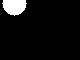
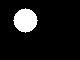

In [13]:
neighborhood_mask = make_neighborhood_mask(feats_height, feats_width, size=12, shape="circle")

mp.show_images(
    {f"{(i, j)}": neighborhood_mask[i, j].cpu().numpy() for i, j in [[3, 14], [20, 25]]},
    height=DISPLAY_HEIGHT,
)

To understand how it works, let's do it for one frame only.
The "context" contains only the first frame and the "current frame" is the second one.

In [14]:
import torch

# ---- choose device ----
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ---- first frame ----
torch._dynamo.maybe_mark_dynamic(first_frame, (1, 2))
first_feats = forward(model, first_frame.to(device))  # [h, w, D]
print(f"First feats:   {first_feats.shape} on {first_feats.device}")

# ---- current frame ----
frame_idx = 1
current_frame_pil = frames[frame_idx]
current_frame = transform(current_frame_pil).to(device)  # [3, H, W]
torch._dynamo.maybe_mark_dynamic(current_frame, (1, 2))
current_feats = forward(model, current_frame)  # [h", w", D]
print(f"Current feats: {current_feats.shape} on {current_feats.device}")

# ---- propagate ----
current_probs = propagate(
    current_feats,                           # [h", w", D]
    context_features=first_feats.unsqueeze(0).to(device),  # [1, h, w, D]
    context_probs=first_probs.unsqueeze(0).to(device),     # [1, h, w, M]
    neighborhood_mask=neighborhood_mask.to(device),        # [h", w", h, w]
    topk=5,
    temperature=0.2,
)  # [h", w", M]
print(f"Current probs: {current_probs.shape} on {current_probs.device}")


Using device: cuda
First feats:   torch.Size([60, 80, 384]) on cuda:0
Current feats: torch.Size([60, 80, 384]) on cuda:0
Current probs: torch.Size([60, 80, 6]) on cuda:0


Then, we upsample the predicted probabilities and postprocess them.

Finally, we visualize:
- The first frame with its ground truth next to the second frame with the predicted masks.
- The per-mask probabilties predicted for the second frame.

Using device: cuda


First frame,Second frame
,

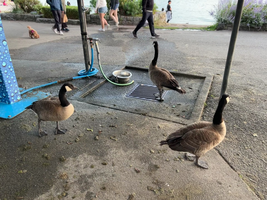
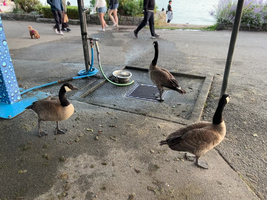
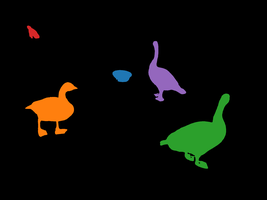
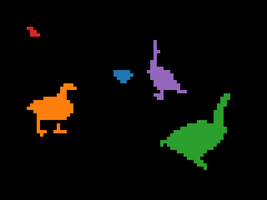

Mask 0,Mask 1,Mask 2,Mask 3,Mask 4,Mask 5

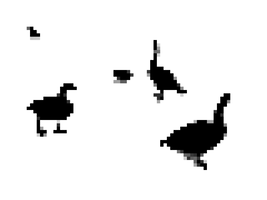
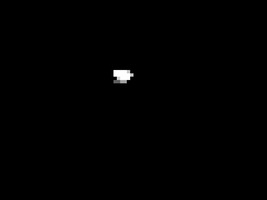
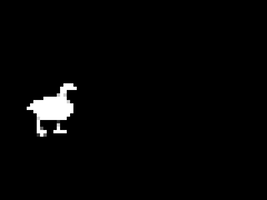
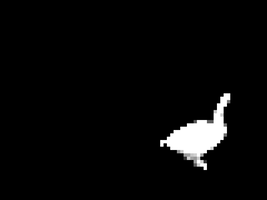
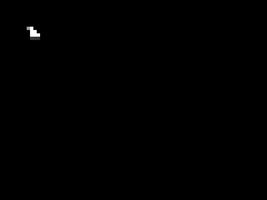
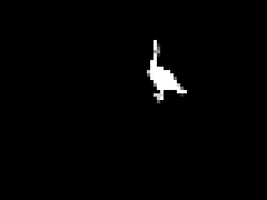

In [15]:
import torch
import torch.nn.functional as F

# ---- pick device ----
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def postprocess_probs(
    probs: torch.Tensor,  # [B, M, H', W']
) -> torch.Tensor:
    # normalize per-mask
    vmin = probs.flatten(2, 3).min(dim=2).values  # [B, M]
    vmax = probs.flatten(2, 3).max(dim=2).values  # [B, M]
    probs = (probs - vmin[:, :, None, None]) / (vmax[:, :, None, None] - vmin[:, :, None, None])
    probs = torch.nan_to_num(probs, nan=0)
    return probs  # [B, M, H', W']

# ---- prepare probabilities ----
p = current_probs.to(device).movedim(-1, -3).unsqueeze(0)  # [1, M, h", w"]
p = F.interpolate(p, size=(mask_height, mask_width), mode="nearest")  # [1, M, H', W']
p = postprocess_probs(p).squeeze(0)  # [M, H', W']

# ---- convert to numpy (always via .cpu()) ----
current_pred_np = p.argmax(0).cpu().numpy()    # [H', W']
current_probs_np = p.cpu().numpy()             # [M, H', W']
del p

# ---- visualization ----
mp.show_images(
    [
        frames[0],
        current_frame_pil,
        mask_to_rgb(first_mask_np, num_masks),
        mask_to_rgb(current_pred_np, num_masks),
    ],
    titles=["First frame", "Second frame", "", ""],
    columns=2,
    height=DISPLAY_HEIGHT,
)

mp.show_images(current_probs_np, titles=[f"Mask {i}" for i in range(num_masks)], height=DISPLAY_HEIGHT)


## Process video

All clear? Time to do it for real!

This time we will process all frames, using a queue of context frames and a queue context mask probabilities.
The queues will contain a limited number of the most recent frames, determined by `max_context_length`.
The first frame is always included in the context and doesn't need to go in the queue.

Let's define all hyperparameters in one place.

In [16]:
# MAX_CONTEXT_LENGTH = 7
# NEIGHBORHOOD_SIZE = 12
# NEIGHBORHOOD_SHAPE = "circle"
# TOPK = 5
# TEMPERATURE = 0.2

Let's go!

The predicted mask probabilities and the masks, at the original mask resolution, will be stored in `mask_predictions` and `mask_probabilities`.

In [17]:
# import torch
# import torch.nn.functional as F
# import time, datetime
# from tqdm import tqdm

# # ---- select device ----
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # ---- init tensors ----
# mask_predictions = torch.zeros(
#     [num_frames, mask_height, mask_width],
#     dtype=torch.uint8,
#     device=device
# )  # [T, H', W']
# mask_predictions[0, :, :] = torch.from_numpy(first_mask_np).to(device)

# mask_probabilities = torch.zeros(
#     [num_frames, num_masks, mask_height, mask_width],
#     device=device
# )  # [T, M, H', W']
# mask_probabilities[0, :, :, :] = (
#     F.one_hot(torch.from_numpy(first_mask_np).long().to(device), num_masks)
#       .movedim(-1, -3)
# )

# features_queue: list[torch.Tensor] = []
# probs_queue: list[torch.Tensor] = []

# # make neighborhood mask on same device
# neighborhood_mask = make_neighborhood_mask(
#     feats_height,
#     feats_width,
#     size=NEIGHBORHOOD_SIZE,
#     shape=NEIGHBORHOOD_SHAPE,
#     device=device
# )  # [h", w", h, w]

# # ---- processing loop ----
# start = time.perf_counter()
# for frame_idx in tqdm(range(1, num_frames), desc="Processing"):
#     # Extract features for the current frame
#     current_frame_pil = frames[frame_idx]
#     current_frame = transform(current_frame_pil).to(device)  # [3, H, W]
#     torch._dynamo.maybe_mark_dynamic(current_frame, (1, 2))
#     current_feats = forward(model, current_frame)  # [h", w", D]

#     # Context features and probabilities
#     context_feats = torch.stack([first_feats, *features_queue], dim=0).to(device)
#     context_probs = torch.stack([first_probs, *probs_queue], dim=0).to(device)
#     torch._dynamo.maybe_mark_dynamic(context_feats, 0)
#     torch._dynamo.maybe_mark_dynamic(context_probs, (0, 3))

#     # Propagate
#     current_probs = propagate(
#         current_feats,
#         context_feats,
#         context_probs,
#         neighborhood_mask,
#         TOPK,
#         TEMPERATURE,
#     )  # [h", w", M]

#     # Update queues
#     features_queue.append(current_feats)
#     probs_queue.append(current_probs)
#     if len(features_queue) > MAX_CONTEXT_LENGTH:
#         features_queue.pop(0)
#     if len(probs_queue) > MAX_CONTEXT_LENGTH:
#         probs_queue.pop(0)

#     # Upsample + postprocess
#     current_probs = F.interpolate(
#         current_probs.movedim(-1, -3)[None, :, :, :],
#         size=(mask_height, mask_width),
#         mode="nearest",
#     )  # [1, M, H', W']
#     current_probs = postprocess_probs(current_probs)  # [1, M, H', W']
#     current_probs = current_probs.squeeze(0)

#     mask_probabilities[frame_idx, :, :, :] = current_probs
#     pred = torch.argmax(current_probs, dim=0).to(dtype=torch.uint8)
#     mask_predictions[frame_idx, :, :] = pred

# # ---- synchronize only if on CUDA ----
# if device == "cuda":
#     torch.cuda.synchronize()

# end = time.perf_counter()
# print(f"Processing time:    {datetime.timedelta(seconds=round(end - start))}")
# print(f"Mask probabilities: {mask_probabilities.shape} on {mask_probabilities.device}")
# print(f"Mask predictions:   {mask_predictions.shape} on {mask_predictions.device}")


Let's visualize a few frames and a video of the result.

In [18]:
# import mediapy as mp

# mp.show_images(
#     [frames[i].convert("RGB") for i in selected_frames]
#     + [mask_to_rgb(mask_predictions[i], num_masks) for i in selected_frames],
#     titles=[f"Frame {i}" for i in selected_frames] + [""] * len(selected_frames),
#     columns=len(selected_frames),
#     height=DISPLAY_HEIGHT,
# )

# mp.show_videos(
#     {
#         "Input": [np.array(frame) for frame in frames],
#         "Pred": mask_to_rgb(mask_predictions, num_masks),
#     },
#     height=DISPLAY_HEIGHT,
#     fps=24,
# )
# mp.show_videos(
#     {f"Prob {i}": mask_probabilities[:, i].numpy() for i in range(num_masks)},
#     height=DISPLAY_HEIGHT,
#     fps=24,
# )

# Conclusion

This notebook showed how to use DINOv3 for video segmentation tracking.
It should be fairly straightforward to run it to your own video and masks.
The notebook hyperparameters can also be adjusted to see the effect on the results.

Let's discuss GPU memory usage:
- The ViT-L model takes approximately 1.1 GB to load.
- The similarity matrix `dot` inside `propagate()` can get pretty big,
  especially at higher resolution and longer context length.

To reduce memory usage and increase speed, the notebook is already set up to work with `torch.compile()`.
In particular, note the use of `torch._dynamo.maybe_mark_dynamic()` to mark a few dimensions as dynamic
to avoid too many recompilations. To enable compilation, just set `disable` to `False` in the
`@torch.compile()` decorators for the `propagate()` and `forward()` functions.

If you are low on memory, it also possible to use a smaller model and
reduce the forward resolution, but tracking results will look worse.

In [19]:
print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 2**30:.1f} GB")

Peak GPU memory: 0.5 GB
